# Задание 1

Сравнить МНК-оценку для линейной регрессии с методом наименьших модулей в случае, когда шум порожден из распределения Лапласа. Когда оценки совпадают, а когда сильно различаются?

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

from scipy.optimize import minimize

Задача линейной регрессии с шумом (распределенным по Лапласу):

$$ y = X \beta + \epsilon , \quad \epsilon \sim Laplace(\mu, \sigma) \\\beta ~ - ~ ?$$

Метод наименьших квадратов (MSE):
$$ \beta = arg \min_\beta \sum_{i=1}^{n} (y_i - \sum_{j=0}^k \beta_j X_{ij} ) ^ 2 $$

Метод наименьших модулей (LAE):
$$ \beta = arg \min_\beta \sum_{i=1}^{n} |y_i - \sum_{j=0}^k \beta_j X_{ij} | $$


Теория: МНМ дает максимум функции правдоподобия в случае ошибок, распределенных именно по Лапласу, в то время как МНК дает максимум функции правдободобия при нормальных ошибках.

Напишем функцию, генерирующую выборку (регрессоры и отклик) в соответствии с требованиями:

In [8]:
def generate(seed, n, k, min_x=-5.0, max_x=5.0, min_b=-100.0, max_b=100.0):
    rs = np.random.RandomState(seed)
    X = rs.uniform(min_x, max_x, size=(n, k))

    b_true = rs.uniform(min_b, max_b, size=k)

    d = np.sqrt(0.05 * np.mean(np.abs(b_true)))  # dispersion = 2d^2 (for laplace) ~ 10% of avg
    noise = rs.laplace(scale=d, size=n).reshape(n, 1)
    y = X.dot(b_true.reshape(k, 1)) + noise

    return X, y, b_true

Будем использовать метод `scipy.optimize.minimize`, чтобы находить минимум функционала (функционала качества). Напишем функцию, вычисляющую функционал (параметр `p` отвечает за выбор квадрата или модуля):

In [7]:
def func(x, y, X, p):
    # x представляет здесь бетта
    return np.linalg.norm(y - X.dot(x.reshape(x.shape[0], 1)), ord=p) ** 2

Методы `MSE` и `MAE` будут возвращать решения в соотвествии с МНК и методом наименьших модулей соответственно.

In [35]:
def MSE(X, y):
    x0 = np.zeros(X.shape[1])
    return minimize(func, x0, (y, X, 2)).x

def LAE(X, y):
    x0 = np.zeros(X.shape[1])
    return minimize(func, x0, (y, X, 1)).x

#### Проведем эксперимент 
Cгенерируем выборки и найдем оценку $\beta$ двумя методами. Будем считать норму разности найденных оценок (score).

In [28]:
iters = 100  # количество экспериментов

n = 100  # размер тренировочной выборки
k = 5  # количество регрессоров

scores = []

for i in range(iters):
    X, y, b_true = generate(i, n, k)
    b1 = MSE(X, y)
    b2 = LAE(X, y)
    score = np.linalg.norm(b1 - b2)
    scores.append(score)

scores = np.array(scores)

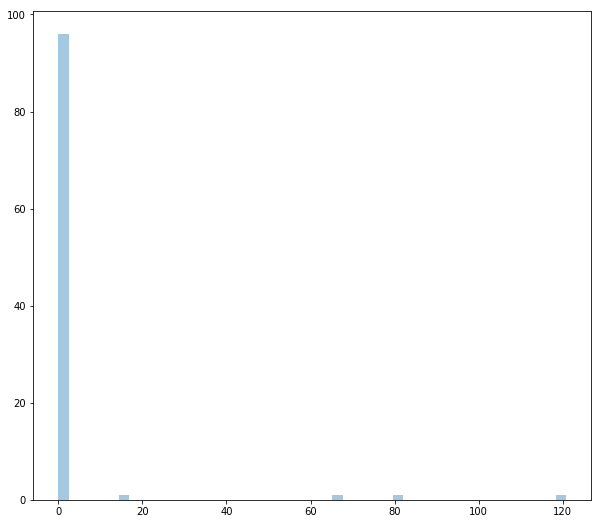

In [29]:
plt.rcParams['figure.figsize'] = (10, 9)
_ = sns.distplot(scores, kde=False)

Заметим, что большинство оценок совпадает, однако есть "взрывы" (сильные отличия). Изучим зависимость количества взрывов от параметров выборок. (Выбросы определяем эвристикой "score > 1", она имеет смысл, если посмотреть на значения score, которые получаются).

#### Зависимость от размера выборки ($n$):

In [46]:
iters = 50
k = 5

blows = []

for n in range(50, 1000, 50):
    blow = 0
    for i in range(iters):
        X, y, b_true = generate(i, n, k)
        b1 = MSE(X, y)
        b2 = LAE(X, y)
        score = np.linalg.norm(b1 - b2)
        if score > 1:
            blow += 1
    blows.append(blow / iters)

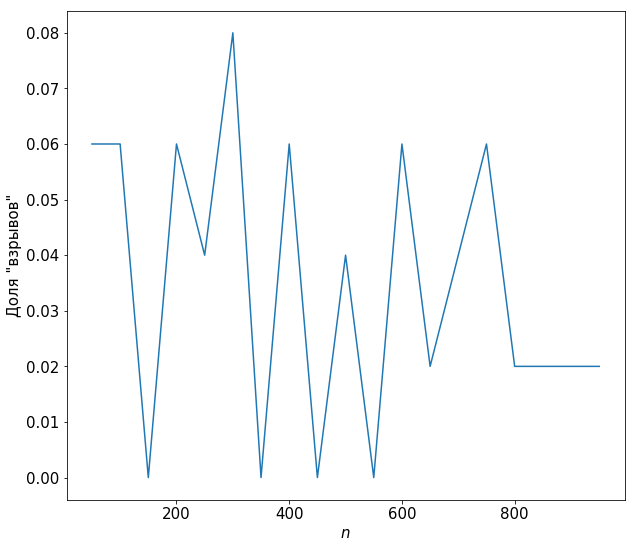

In [49]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (10, 9)
plt.plot(range(50, 1000, 50), blows)
plt.xlabel('$n$')
plt.ylabel('Доля "взрывов"')
_ = plt.show()

Видим, что размер выборки слабо влияет на количество взрывов (не влияет).

#### Зависимость от количества признаков ($k$):

In [ ]:
iters = 35
n = 100

kblows = []

for k in range(5, 25):
    print(k)
    blow = 0
    for i in range(iters):
        X, y, b_true = generate(i, n, k)
        b1 = MSE(X, y)
        b2 = LAE(X, y)
        score = np.linalg.norm(b1 - b2)
        if score > 1:
            blow += 1
    kblows.append(blow / iters)

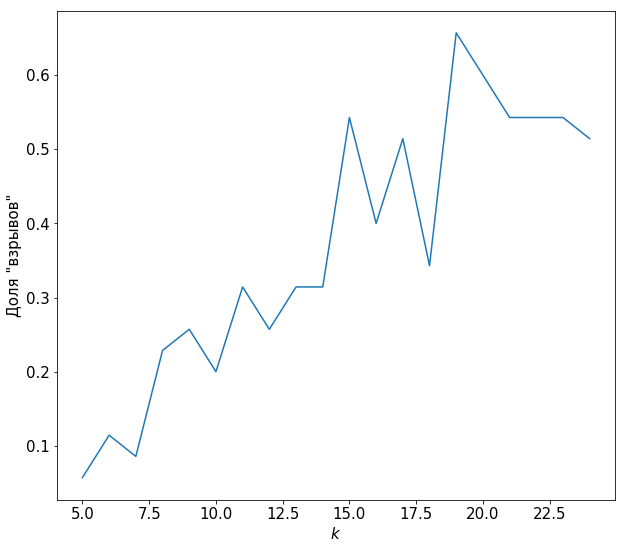

In [57]:
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (10, 9)
plt.plot(range(5, 25), kblows)
plt.xlabel('$k$')
plt.ylabel('Доля "взрывов"')
_ = plt.show()

Доля выбросов явно растет с ростом количества регрессоров. Но стоит учесть так же, что с их ростом растет и дисперсия, то есть эвристика "score > 1" становится более неточной.

#### Вывод

Вероятно, взрывы связаны с особенностями решателя (в данном случае bfgs). Возможно, при негладкой оптимизации, могут возникать такие эффекты.